In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix


In [9]:
# Step 1: Define paths
train_dir = "Dataset/train"
val_dir = "Dataset/val"
test_dir = "Dataset/test"

IMG_SIZE = 224
BATCH_SIZE = 32

# Step 2: Create ImageDataGenerators
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Step 3: Load images from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 2045 images belonging to 5 classes.
Found 2045 images belonging to 5 classes.
Found 2045 images belonging to 5 classes.


In [10]:
# Load base model without top layers (include_top=False)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze base model layers (transfer learning)
base_model.trainable = False

# Add custom classification layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output_layer = Dense(5, activation='softmax')(x)  # 5 classes

# Final model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [11]:
# Model training
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,  # Chaaho to 5 rakh sakte ho speed ke liye
    validation_data=val_generator,
    validation_steps=len(val_generator)
)


C:\Users\rites\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.4256 - loss: 1.4098 - val_accuracy: 0.7428 - val_loss: 0.7834
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.7564 - loss: 0.7323 - val_accuracy: 0.8117 - val_loss: 0.5575
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.8096 - loss: 0.5492 - val_accuracy: 0.8533 - val_loss: 0.4586
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.8292 - loss: 0.5072 - val_accuracy: 0.8621 - val_loss: 0.4023
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.8306 - loss: 0.4793 - val_accuracy: 0.8787 - val_loss: 0.3589
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.8555 - loss: 0.4085 - val_accuracy: 0.8895 - val_loss: 0.3338
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.8699 - loss: 0.3680 - val_accuracy: 0.9007 - val_loss: 0.3052
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.8795 - loss: 0.3568 - val_accuracy: 0.9032 - val_loss:

In [18]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

loss, accuracy = model.evaluate(test_generator)
print(f"\n✅ Test Accuracy: {accuracy * 100:.2f}%")  # <- Ye zaroori hai


Found 2045 images belonging to 5 classes.
64/64 ━━━━━━━━━━━━━━━━━━━━ 31s 486ms/step - accuracy: 0.9366 - loss: 0.2071

✅ Test Accuracy: 92.22%


In [21]:
!pip install seaborn


     ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
     ---- ---------------------------------- 30.7/294.9 kB 1.3 MB/s eta 0:00:01
     ----- ------------------------------- 41.0/294.9 kB 487.6 kB/s eta 0:00:01
     ------------- ---------------------- 112.6/294.9 kB 930.9 kB/s eta 0:00:01
     ----------------------------- -------- 225.3/294.9 kB 1.4 MB/s eta 0:00:01
     -------------------------------------- 294.9/294.9 kB 1.4 MB/s eta 0:00:00
     ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
      --------------------------------------- 0.2/11.1 MB 14.1 MB/s eta 0:00:01
     - -------------------------------------- 0.3/11.1 MB 3.6 MB/s eta 0:00:03
     - -------------------------------------- 0.5/11.1 MB 3.3 MB/s eta 0:00:04
     -- ------------------------------------- 0.7/11.1 MB 3.6 MB/s eta 0:00:03
     --- ------------------------------------ 0.8/11.1 MB 3.5 MB/s eta 0:00:03
     ---- ----------------------------------- 1.1/11.1 MB 4


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


64/64 ━━━━━━━━━━━━━━━━━━━━ 50s 769ms/step
📋 Classification Report:

              precision    recall  f1-score   support

   cardboard       0.96      0.95      0.96       403
       glass       0.96      0.89      0.92       501
       metal       0.85      0.96      0.90       410
       paper       0.93      0.95      0.94       594
       trash       0.90      0.69      0.78       137

    accuracy                           0.92      2045
   macro avg       0.92      0.89      0.90      2045
weighted avg       0.92      0.92      0.92      2045



C:\Users\rites\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


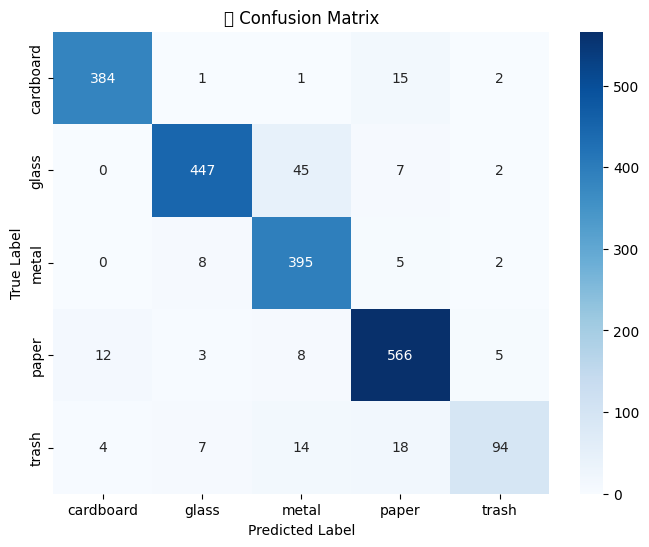

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 🔁 Predict test data
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# ✅ True Labels
y_true = test_generator.classes

# ✅ Class Labels
class_labels = list(test_generator.class_indices.keys())

# 📋 Classification Report
print("📋 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# 📊 Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("🧠 Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [25]:
model.save("garbage_classifier_model.keras")


In [26]:
import json

# Save class indices (like {'cardboard': 0, 'glass': 1, ...})
with open("class_indices.json", "w") as f:
    json.dump(train_generator.class_indices, f)

print("Class labels saved in class_indices.json")


Class labels saved in class_indices.json
